Daily Temperature

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2024-04-15 14:40:15--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2024-04-15 14:40:15 (8.40 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



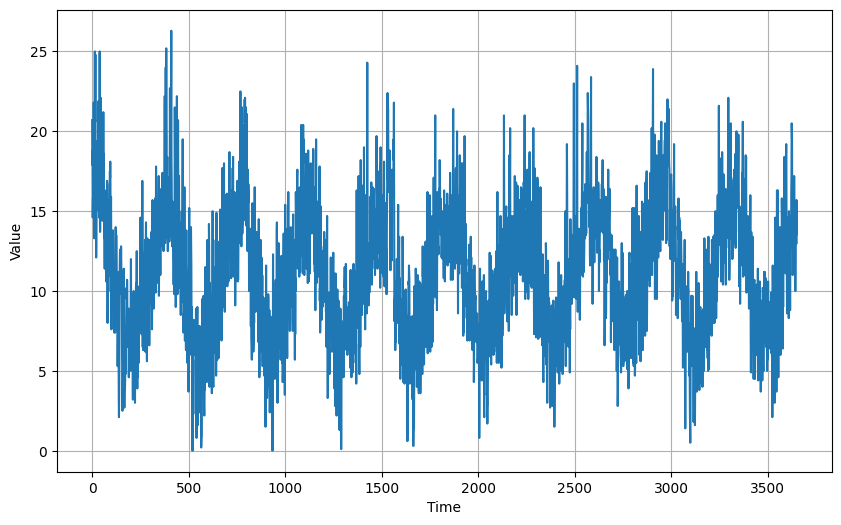

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
series

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)
series = series.flatten()
series

[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 ...
 [0.51330798]
 [0.59695817]
 [0.49429658]]


array([0.78707224, 0.68060837, 0.7148289 , ..., 0.51330798, 0.59695817,
       0.49429658])

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional


In [ ]:

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)


In [ ]:
list(train_set.take(1))[0][0].shape

TensorShape([64, 60, 1])

In [ ]:
list(train_set.take(1))[0][1].shape

TensorShape([64, 60, 1])

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

In [ ]:
x = list(train_set.as_numpy_iterator())

In [ ]:
x[0][0].shape

(64, 60, 1)

In [ ]:
x[0][1].shape

(64, 60, 1)

In [ ]:

tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(5)
])
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100)

Epoch 1/100
39/39 [==============================] - 6s 13ms/step - loss: 7.0500 - mae: 7.5410
Epoch 2/100
39/39 [==============================] - 1s 11ms/step - loss: 2.8717 - mae: 3.3407
Epoch 3/100
39/39 [==============================] - 1s 11ms/step - loss: 2.3985 - mae: 2.8577
Epoch 4/100
39/39 [==============================] - 1s 11ms/step - loss: 1.7322 - mae: 2.1787
Epoch 5/100
39/39 [==============================] - 1s 11ms/step - loss: 1.5884 - mae: 2.0314
Epoch 6/100
39/39 [==============================] - 1s 11ms/step - loss: 1.5477 - mae: 1.9886
Epoch 7/100
39/39 [==============================] - 1s 11ms/step - loss: 1.5282 - mae: 1.9680
Epoch 8/100
39/39 [==============================] - 1s 11ms/step - loss: 1.5168 - mae: 1.9570
Epoch 9/100
39/39 [==============================] - 1s 11ms/step - loss: 1.5060 - mae: 1.9457
Epoch 10/100
39/39 [==============================] - 1s 11ms/step - loss: 1.4979 - mae: 1.9375
Epoch 11/100
39/39 [=============================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 dense (Dense)               (None, None, 32)          2080      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Sunspot

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2024-04-15 15:24:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-04-15 15:24:12 ERROR 404: Not Found.



In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

StopIteration: 

In [ ]:
series

In [ ]:
scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
print(series)

In [ ]:
series = series.flatten()

In [ ]:
series

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
len(x_train)

In [ ]:
len(x_valid)

In [ ]:
def load_image_test(image, label):
  scaled_image = image / 255.0
  return scaled_image, label

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds


In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', monitor='mae', verbose=0, save_best_only=True)

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)

In [ ]:
# (64, 60, 7)

In [ ]:
list(train_set.take(1))

In [ ]:
model = Sequential([
      LSTM(64, return_sequences=True, input_shape=[None, 7]),
      Dense(32, activation='relu'),
      Dense(7)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
# history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
model.summary()

In [ ]:
model = Sequential([
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
model = Sequential([
      Bidirectional(LSTM(64, return_sequences=True)),
      Bidirectional(LSTM(64, return_sequences=True)),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
                    Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
                    LSTM(64, return_sequences=True),
                    LSTM(64, return_sequences=True),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

Conv1D

In [ ]:
clear_session()
tf.random.set_seed(0)
np.random.seed(0)

train_set = windowed_dataset(x_train, window_size=60, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = Sequential([
      Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=[None, 1]),
      LSTM(64, return_sequences=True),
      LSTM(64, return_sequences=True),
      Dense(32, activation='relu'),
      Dense(16, activation='relu'),
      Dense(1)
])
# optim = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[checkpoint])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
model.summary()

Forcast

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1 , drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(16, 8))
    plot_series(time_valid, x_valid)
    plot_series(time_valid, rnn_forecast)
    labels = ['Real', 'Predicted']
    plt.legend(labels)
    plt.show()

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()